In [1]:
import csv
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
def loading(filename = 'iris_data.csv'):
    """
    Loading the csv file

    Parameters
    ----------
    filename
        Name of the file to be loaded
        
    Returns
    -------
    dataset
        A 2D numpy array representing data.
    m
        (int) Total number of samples
    n
        (int) Total numbers of features
    """
    file = open(filename,'r')
    csv_reader = csv.reader(file)

    m,n = 0,0
    data = []
    labels = {'Iris-setosa': [1,0,0], 'Iris-versicolor': [0,1,0], 'Iris-virginica': [0,0,1]}
    for line in csv_reader:
        if n==0:
            n = len(line)-1
        if len(line)==0:
            break
        m+=1
        data.append([float(i) for i in line[:-1]] + labels[line[-1]])

    dataset = np.array(data, dtype=np.float16)
    return dataset, m, n, labels

dataset, m, n, labels = loading()

In [3]:
def mean_norm(dataset,m,n):
    """
    Mean normalisation of the loaded dataset

    Parameters
    ----------
    dataset
        A 2D numpy array representing data.
    m
        (int) Total number of samples
    n
        (int) Total numbers of features
        
    Returns
    -------
    dataset
        Modified dataset.
    """
    avg = (1/m)*dataset[:,:n].sum(axis=0)
    dataset[:,:n] = (dataset[:,:n] - avg)/(np.max(dataset[:,:n],axis=0) - np.min(dataset[:,:n],axis=0))
    return dataset

dataset = mean_norm(dataset,m,n)

In [4]:
def test_train_split(dataset, m, n):
    """
    Spliting the dataset into corresponding arrays.

    Parameters
    ----------
    dataset
        A 2D numpy array representing data.
    m
        (int) Total number of samples
    n
        (int) Total numbers of features
        
    Returns
    -------
    x_train
        A 2-D numpy array of training feature
    x_test
        A 2-D numpy array of testing feature
    y_train
        A 2-D numpy array of training label
    y_test
        A 2-D numpy array of testing label
    """
    frac = 0.75
    
    np.random.shuffle(dataset)
    split = int(m*frac)
    
    x_train = dataset[:split, :n]
    y_train = dataset[:split, n:]
    x_test = dataset[split:, :n]
    y_test = dataset[split:, n:]
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = test_train_split(dataset, m, n)

In [5]:
def para_creation(n_inp_node = n, n_hidden_node = [5,4], n_out_node = y_train.shape[1]):
    """
    Creates random parameters.

    Parameters
    ----------
    n_inp_node
        (int) no. of input nodes ( also equal to no. of features ).
    n_hidden_node
        (int) no. of hidden nodes
    n_out_node
        (int) no. of output nodes ( also equal to no. of labels ).
        
    Returns
    -------
    w
        A 2-D numpy array of weights.
    b
        A 2-D numpy array of bias.
    """
    n_nodes = [n_inp_node] + n_hidden_node + [n_out_node]
    w,b=[],[]
    for i,j in zip(n_nodes[:-1],n_nodes[1:]):
        w.append(np.random.randn(i,j))
        b.append(np.random.randn(j,1))
        
    return w,b

w,b = para_creation()

In [6]:
def forward_prop(x_train, w, b, non_linear_type = 'sigmoid'):
    """
    Forward Propagation.

    Parameters
    ----------
    x_train
        A 2-D numpy array of training features.
    w
        A 2-D numpy array of weights.
    b
        A 2-D numpy array of bias.
    non_linear_type
        (string) Tells about the activation function
        
    Returns
    -------
    a
        Returns 2-D numpy array of prediction
    """
    # non_linear_type = 'relu'
    a=[x_train]
    lyr = 0
    for weight, bias in zip(w,b):
        # linear part
        val = np.dot(a[lyr],w[lyr])+b[lyr].T
        lyr += 1
        # Sigmoid part
        if non_linear_type == 'sigmoid':
            val = 1/(1+np.exp(-val))

        # Leaky ReLU part
        if non_linear_type == 'relu':
            val = np.maximum(0.1*val,val)
            
            # Softmax at last layer
            if lyr == len(w):
                val = np.exp(val)
                val /= val.sum(axis=1, keepdims=True)

        a.append(val) 
    return a

a = forward_prop(x_train, w, b)

In [7]:
def cost_function(m, actual = y_train, predicted = a[-1]):
    """
    Calculates cost function.

    Parameters
    ----------
    m
        Total number of samples.
    actual
        A 2-D numpy array of labels.
    predicted
        A 2-D numpy array of predictions.
       
    Returns
    -------
    cost
        Returns cost of prediction
    """
    cost = (-1/m)*(actual*np.log(predicted) + (1-actual)*np.log(1-predicted)).sum()
    return cost

cost = cost_function(m)

In [8]:
def backward_prop(y_train, w, b, a, learning_rate = 0.1, non_linear_type = 'sigmoid'):
    """
    Backward Propagation.

    Parameters
    ----------
    y_train
        A 2-D numpy array of training labels.
    w
        A 2-D numpy array of weights.
    b
        A 2-D numpy array of bias.
    a
        A list of 2-D numpy array of predictions.
    learning_rate
        (float) rate of learning
    non_linear_type
        (string) Tells about the activation function
        
    Returns
    -------
    w
        A 2-D numpy array of weights.
    b
        A 2-D numpy array of bias.
    """
    # non_linear_type = 'relu'
    n = len(w)
    dz = y_train - a[-1]
    for index in range(-1,-n-1,-1):
        # linear part
        dw = (1/m)*np.dot(a[index - 1].T,dz)
        db = (1/m)*np.sum(dz, axis = 0, keepdims = True).T
        w[index] += learning_rate*dw
        b[index] += learning_rate*db
        # Sigmoid
        if non_linear_type == 'sigmoid':
            dz = np.dot(dz, w[index].T)*(a[index-1]*(1-a[index-1]))
        # ReLU
        if non_linear_type == 'relu':
            dz = np.dot(dz, w[index].T)*(0.1*(a[index-1]<0)+(a[index-1]>0))
        
    return w, b

w,b = backward_prop(y_train, w, b, a)

In [9]:
def predict(x_test, w, b, non_linear_type):
    """
    Prediction function.

    Parameters
    ----------
    x_test
        A 2-D numpy array of testing features.
    w
        A 2-D numpy array of weights.
    b
        A 2-D numpy array of bias.
    non_linear_type
        (string) Tells about the activation function
        
    Returns
    -------
    a
        Returns 2-D numpy array of prediction
    """
    a = forward_prop(x_test, w, b, non_linear_type)
    return a[-1]

In [10]:
def confusion_matrix(predicted, actual, labels):
    """
    Evaluation function.

    Parameters
    ----------
    predicted
        A 2-D numpy array of predicted labels.
    actual
        A 2-D numpy array of actual labels.
    labels
        A list of labels.
    non_linear_type
        (string) Tells about the activation function
        
    Returns
    -------
    None
    """
    print('=================\n Model evaluation\n=================')
    print('labels are: {}\n'.format(labels))
    conf_mat = np.zeros((3,3), dtype = np.uint8)
    true_positive, total = 0, 0
    for pred, actl in zip(predicted,actual):
        conf_mat[np.argmax(actl), np.argmax(pred)]+=1
        if np.argmax(actl) == np.argmax(pred):
            true_positive += 1
        total += 1
    print(conf_mat)
    print('\nAccuracy is: {}/{} = {}%'.format(true_positive, total, true_positive*100/total))
    

[ 0.84130746  0.11742693]


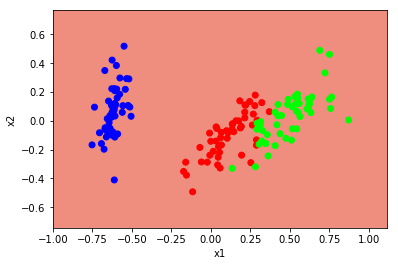

In [11]:
def plot_decision_boundary(dataset, m, n, w, b, non_linear_type = 'relu'):
    """
    Data visualisation.

    Parameters
    ----------
    dataset
        A 2-D numpy array of data.
    m
        (int) Total number of samples
    n
        (int) Total numbers of features
    w
        A 2-D numpy array of weights.
    b
        A 2-D numpy array of bias.
    non_linear_type
        (string) Tells about the activation function
        
    Returns
    -------
    None
    """
    pca = PCA(n_components=2)
    new_dataset = pca.fit_transform(dataset[:,:n])
    print(pca.explained_variance_ratio_)
    # Set min and max values and give it some padding
    x_min, x_max = new_dataset[:,0].min() - 0.25, new_dataset[:,0].max() + 0.25
    y_min, y_max = new_dataset[:,1].min() - 0.25, new_dataset[:,1].max() + 0.25
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    #Z = model(np.c_[xx.ravel(), yy.ravel()])
    test_cases = pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
    z = predict(test_cases, w, b, non_linear_type)
    z = z.argmax(axis=1)
    z = z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, z, cmap=plt.cm.brg, alpha = 0.5)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(new_dataset[:,0], new_dataset[:,1], c=np.argmax(dataset[:,n:], axis=1), cmap=plt.cm.brg)
    plt.show()
    return

plot_decision_boundary(dataset, m, n, w, b)

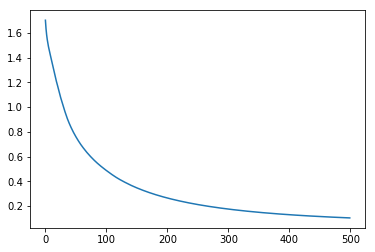

 Model evaluation
labels are: {'Iris-setosa': [1, 0, 0], 'Iris-versicolor': [0, 1, 0], 'Iris-virginica': [0, 0, 1]}

[[15  0  0]
 [ 0  8  1]
 [ 0  1 13]]

Accuracy is: 36/38 = 94.73684210526316%
[ 0.84130746  0.11742693]


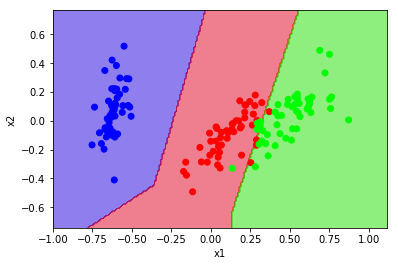

In [12]:
def main_function(n_iteration = 20):
    
    # Loading the dataset
    dataset, m, n, labels = loading()
    
    # Mean normalisation
    dataset = mean_norm(dataset,m,n)
    
    # Test train split
    x_train, x_test, y_train, y_test = test_train_split(dataset, m, n)
    # Parameter creation
    w,b = para_creation(n_inp_node = n, n_hidden_node = [4,4], n_out_node = y_train.shape[1])
    
    # Iterations of training
    cost = []
    for iterations in range(n_iteration):
        # Forward Propagation
        a = forward_prop(x_train, w, b, non_linear_type = 'relu')
        
        # Cost calculation
        cost.append(cost_function(m, actual = y_train, predicted = a[-1]))
        
        # Backward propagation
        w, b = backward_prop(y_train, w, b, a, non_linear_type = 'relu')
        
    plt.plot(range(n_iteration), cost)
    plt.show()
    
    # Testing
    prediction = predict(x_test, w, b, non_linear_type = 'relu')
    
    # accuracy
    confusion_matrix(predicted = prediction, actual = y_test, labels = labels)
    
    # visualisation
    plot_decision_boundary(dataset, m, n, w, b)
    
main_function(n_iteration = 500)